In [1]:
from kalman_gst import *  
from pygsti.modelpacks import smq2Q_XYICNOT as std

In [2]:
SEED = 2021
SAMPLES = 256
np.random.seed(SEED)

In [7]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

# Example 1

Fixed FOGI model with different start points

In [3]:
# setup the datagen model
max_fogi_error_rate = 0.05
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [4]:
# make an edesign and simulate the data
maxLengths = [1,2,4,8,16]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [5]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.6s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.2s


In [7]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

In [5]:
circ_list = maxlength_edesign.circuit_lists[-1]

In [ ]:
post_model, post_covar, saved_data = filter_dataset(target_model, 0.1*np.eye(target_model.num_params), dataset, circ_list, 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

 42%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                | 3695/8740 [28:57<1:31:31,  1.09s/it]

In [11]:
plt_spacing = 20
%matplotlib inline
yrange = [-4.5, 0]

ValueError: diag requires an array of at least two dimensions

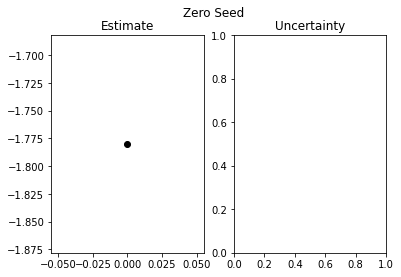

In [12]:
make_error_plot('Zero Seed', zero_model_vectors, mdl_datagen.to_vector(), zero_covars, yrange, mle_estimates, germ_length_ranges, plt_spacing)